# Source

[@susanli2016](https://github.com/susanli2016/NLP-with-Python/blob/master/Multi-Class%20Text%20Classification%20LSTM%20Consumer%20complaints.ipynb)

In [1]:
import pandas as pd

In [9]:
df = pd.read_csv('../datasets/automation/stage3/training_data_v2.csv')

In [10]:
df = df.drop(['Unnamed: 0'], axis=1)
df.columns
df = df[['tweet', 'emotion']]

In [11]:
df

,tweet,emotion
0,No of Containment Zones in Vijayawada VMC li...,disgust
1,Unlock 1 0 evokes huge response Covid 19 U...,disgust
2,Are people hesitant to venture out Mall in Vi...,joy
3,Minister Vellampalli Srinivas inspects arrange...,sadness
4,In Pics With relaxations given to restaurants...,joy
...,...,...
3031,UNLOCK 1 0 is in Action Unlock1 unlockon...,joy
3032,1 This is how current conditions in kolkata u...,joy
3033,Lockdown5 Shops Selling Non Essential Items...,sadness
3034,30 ज न तक बढ ल कड उन स थ म शर त क स थ य ...,joy


In [45]:
df.emotion.value_counts()

joy        1381
sadness     731
disgust     608
anger       245
fear         71
Name: emotion, dtype: int64

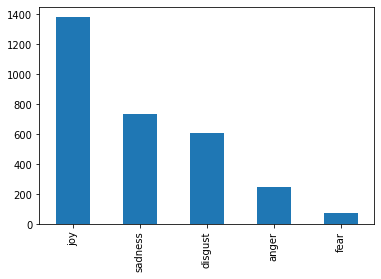

In [18]:
df.emotion.value_counts().plot(kind='bar')

In [24]:
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [28]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text


df['tweet'] = df['tweet'].apply(
    clean_text)

In [29]:
df['tweet']

0       containment zones vijayawada vmc limits may 26...
1       unlock 1 0 evokes huge response covid 19 unloc...
2       people hesitant venture mall vijayawada wearin...
3       minister vellampalli srinivas inspects arrange...
4       pics relaations given restaurants hotels peopl...
                              ...                        
3031    unlock 1 0 action unlock1 unlockone kolkata pi...
3032    1 current conditions kolkata unlockone could h...
3033    lockdown5 shops selling non essential items re...
3034    30 unlock1 lockdownetension lockdown5 arrah bi...
3035    city center korba open 10 9 pm precautionary m...
Name: tweet, Length: 3036, dtype: object

In [30]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12177 unique tokens.


In [31]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3036, 250)


In [32]:
Y = pd.get_dummies(df['emotion']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3036, 5)


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2732, 250) (2732, 5)
(304, 250) (304, 5)


In [65]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
epochs = 100
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[
                    EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 2458 samples, validate on 274 samples
Epoch 1/100
2458/2458 [==============================] - 10s 4ms/sample - loss: 1.3843 - accuracy: 0.4508 - val_loss: 1.2715 - val_accuracy: 0.4453
Epoch 2/100
2458/2458 [==============================] - 8s 3ms/sample - loss: 1.1577 - accuracy: 0.5301 - val_loss: 1.0874 - val_accuracy: 0.5912
Epoch 3/100
2458/2458 [==============================] - 8s 3ms/sample - loss: 0.7396 - accuracy: 0.7526 - val_loss: 0.9503 - val_accuracy: 0.6715
Epoch 4/100
2458/2458 [==============================] - 8s 3ms/sample - loss: 0.4462 - accuracy: 0.8401 - val_loss: 0.9052 - val_accuracy: 0.7117
Epoch 5/100
2458/2458 [==============================] - 8s 3ms/sample - loss: 0.3161 - accuracy: 0.9015 - val_loss: 0.9250 - val_accuracy: 0.6971
Epoch 6/100
2458/2458 [==============================] - 8s 3ms/sample - loss: 0.2110 - accuracy: 0.9361 - val_loss: 1.0151 - val_accuracy: 0.6934
Epoch 7/100
2458/2458 [==============================] - 8s 3ms/sample

In [67]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

304/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test set
  Loss: 0.782
  Accuracy: 0.747


In [40]:
import matplotlib.pyplot as plt

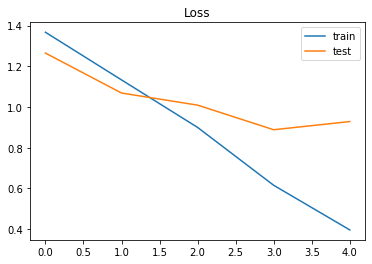

In [41]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

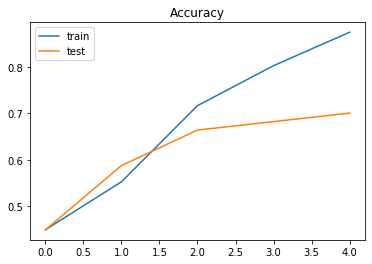

In [44]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [47]:
import numpy as np

In [82]:
new_complaint = ['the lockdown extension is a very bad decision by government']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['joy', 'sadness', 'digust', 'anger', 'fear']
print(pred, labels[np.argmax(pred)])

[[0.11599437 0.28679284 0.1092154  0.38170257 0.10629481]] anger
